# _Imports_, constantes e funções de classificação

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn import svm, tree, ensemble, neighbors, preprocessing

DATASET_NAME = 'dataset.csv'
TEST_SIZE = 0.7
FOLDS_COUNT = 5
MAX_DEPTH = 15
np.random.seed(1000)

class DataSet:
    def __init__(self, dataSet, ignoreColumns, testSize):
        self.df = (pd.read_csv(dataSet)).drop(columns=ignoreColumns)
        
        self.target = (self.df['koi_disposition'] == 'CONFIRMED').astype(int)
        self.df = self.df.drop(columns=['koi_disposition'])
        
        self.features = self.df.shape[1]
                
        self.df = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(self.df.values))
        
        msk = np.random.rand(len(self.df)) < testSize
        self.trainDf = self.df[msk]
        self.trainTarget = self.target[msk]
        
def naiveBayesClassifier(df, output, folds):
    return (cross_val_score(GaussianNB(), df, output, cv=folds)).mean()

def decisionTreeClassifier(df, output, maxDepth, folds):
    clf = tree.DecisionTreeClassifier(max_depth=maxDepth)
    return (cross_val_score(clf, df, output, cv=folds)).mean()
    
def randomForestClassifier(df, output, trainExamples, trainLabels, features, maxDepth, folds):
    clf = ensemble.RandomForestClassifier(n_estimators=features, max_depth=maxDepth)
    clf = clf.fit(trainExamples, trainLabels)
    return (cross_val_score(clf, df, output, cv=folds)).mean()

def knnClassifier(df, output, trainExamples, trainLabels, k, folds):
    clf = (neighbors.KNeighborsClassifier(n_neighbors=k)).fit(trainExamples, trainLabels)
    return (cross_val_score(clf, df, output, cv=folds)).mean()
    
def svmClassifier(df, output, trainExamples, trainLabels, folds):
    results = {}
    
    clf = (svm.SVC(kernel='linear', gamma='auto')).fit(trainExamples, trainLabels)
    results['linear'] = (cross_val_score(clf, df, output, cv=folds)).mean()
    
    clf = (svm.SVC(kernel='rbf', gamma='auto', C = 10.0)).fit(trainExamples, trainLabels)
    results['rbf'] = (cross_val_score(clf, df, output, cv=folds)).mean()
    
    clf = (svm.SVC(kernel='sigmoid', gamma='auto')).fit(trainExamples, trainLabels)
    results['sigmoid'] = (cross_val_score(clf, df, output, cv=folds)).mean()
    
    clf = (svm.SVC(kernel='poly', gamma='auto', degree=8)).fit(trainExamples, trainLabels)
    results['poly'] = (cross_val_score(clf, df, output, cv=folds)).mean()
    
    return results

def adaboostClassifier(df, output, trainExamples, trainLabels, estimatorsCount, folds):
    clf = ensemble.AdaBoostClassifier(n_estimators=estimatorsCount)
    clf = clf.fit(trainExamples, trainLabels)
    return (cross_val_score(clf, df, output, cv=folds)).mean()

# Funções para visualização dos dados

In [10]:
def showDecisionTreeStats(maxDepth):
    decisionTreeScores = [0]
    for i in range(1,maxDepth+1):
        decisionTreeScores.append(decisionTreeClassifier(ds.df, ds.target, i, FOLDS_COUNT))

    print("Acurácia do modelo com altura ilimitada: {}".format(decisionTreeClassifier(ds.df, ds.target, None, FOLDS_COUNT)))
    plt.title('Acurácia de acordo com o aumento da altura da arvore')
    plt.grid(True)
    plt.xlabel('Altura')
    plt.ylabel('Acurácia')
    plt.xlim([1, maxDepth])
    plt.ylim([0.65, 1])
    plt.plot(np.array([score for score in decisionTreeScores]), label="Decision Tree")
    plt.plot(np.array([naiveBayesMeanScore for i in range(0, len(decisionTreeScores))]), label="Naive Bayes")
    plt.legend()
    plt.show()
    
def showKnnStats(kValues):
    knnScores = {}

    for i in range(0,len(kValues)):
        knnScores[kValues[i]] = knnClassifier(ds.df, ds.target, ds.trainDf, ds.trainTarget, kValues[i], FOLDS_COUNT)

    fig, ax = plt.subplots(figsize=(8,8))
    sns.lineplot(x=kValues, y=[v for k,v in knnScores.items()], color='r', ax=ax)
    sns.lineplot(x=kValues, y=[naiveBayesMeanScore for i in knnScores.items()], color='b', ax=ax)    
    ax.legend(['KNN', 'Naive Bayes'], facecolor='w')
    plt.xticks(kValues)
    plt.grid(True)
    plt.show()
    
def showRandomForestStats(maxDepth):
    randomForestUnlimtdDepthScores = [0]
    for i in range(1,ds.features + 1):
        randomForestUnlimtdDepthScores.append(randomForestClassifier(ds.df, ds.target, ds.trainDf, ds.trainTarget, i, None, FOLDS_COUNT))

    randomForestDepthByFeaturesScores = {}
    for i in range(1, maxDepth + 1):
        randomForestDepthByFeaturesScores[i] = [0]
        for j in range(1, ds.features + 1):
            randomForestDepthByFeaturesScores[i].append(randomForestClassifier(ds.df, ds.target, ds.trainDf, ds.trainTarget, j, i, FOLDS_COUNT))

    fig = plt.figure(num=None, figsize=(16, 22))
    gs = gridspec.GridSpec(4, 1, figure=fig, height_ratios=[3,8,8,8])
    ax1 = plt.subplot(gs[0])
    ax1.title.set_text('Acurácia com altura ilimitada x aumento de features')
    ax1.set_xlabel('Features')
    ax1.set_ylabel('Acurácia')
    ax1.set_xlim([1, ds.features])
    ax1.set_yticks([0.91, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98])
    ax1.set_ylim([0.91, 0.98])
    ax1.plot(np.array([score for score in randomForestUnlimtdDepthScores]), label="Random Forest")
    ax1.plot(np.array([naiveBayesMeanScore for i in range(0, len(randomForestUnlimtdDepthScores))]), label="Naive Bayes")
    ax1.legend()
    ax1.grid(True)


    ax2 = plt.subplot(gs[1])
    ax2.title.set_text('Acurácia da altura (de 1 a 5) x aumento de features')
    ax2.set_xlabel('Features')
    ax2.set_ylabel('Acurácia')
    ax2.set_xlim([1, ds.features])
    ax2.set_ylim([0.67, 0.98])
    for j in range(1, 6):
        ax2.plot(np.array([score for score in randomForestDepthByFeaturesScores[j]]), label="RF Depth={}".format(j))
    ax2.plot(np.array([naiveBayesMeanScore for j in range(0, len(randomForestUnlimtdDepthScores))]), label="Naive Bayes")
    ax2.legend()
    ax2.grid(True)

    ax3 = plt.subplot(gs[2])
    ax3.title.set_text('Acurácia da altura (de 6 a 10) x aumento de features')
    ax3.set_xlabel('Features')
    ax3.set_ylabel('Acurácia')
    ax3.set_xlim([1, ds.features])
    ax3.set_ylim([0.905, 0.97])
    for j in range(6, 11):
        ax3.plot(np.array([score for score in randomForestDepthByFeaturesScores[j]]), label="RF Depth={}".format(j))
    ax3.plot(np.array([naiveBayesMeanScore for j in range(0, len(randomForestUnlimtdDepthScores))]), label="Naive Bayes")
    ax3.legend()
    ax3.grid(True)

    ax4 = plt.subplot(gs[3])
    ax4.title.set_text('Acurácia da altura (de 11 a 15) x aumento de features')
    ax4.set_xlabel('Features')
    ax4.set_ylabel('Acurácia')
    ax4.set_xlim([1, ds.features])
    ax4.set_ylim([0.91, 0.97])
    for j in range(11, 15):
        ax4.plot(np.array([score for score in randomForestDepthByFeaturesScores[j]]), label="RF Depth={}".format(j))
    ax4.plot(np.array([naiveBayesMeanScore for j in range(0, len(randomForestUnlimtdDepthScores))]), label="Naive Bayes")
    ax4.legend()
    ax4.grid(True)


    plt.subplots_adjust(hspace=0.25)
    plt.show()

# Instanciar DataSet, e gerar score para _Naive Bayes_

In [7]:
ds = DataSet(DATASET_NAME, ['kepoi_name'], TEST_SIZE)
naiveBayesMeanScore = naiveBayesClassifier(ds.df, ds.target, FOLDS_COUNT)

# Decision Tree
Avaliação da acurácia do modelo utilizando _Decision Tree_, em comparação com o _Naive Bayes_

Acurácia do modelo com altura ilimitada: 0.9405892646691825


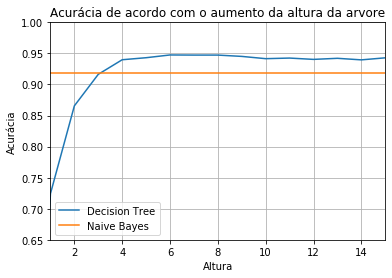

In [8]:
showDecisionTreeStats(MAX_DEPTH)

Podemos ver o aumento da acurácia do modelo de acordo com o aumento da altura da árvore; É notável o aumento no início do gráfico, mostrando o quão ineficaz é esse modelo com uma altura pequena.<br>
A acurácia do modelo com a altura da árvore não sendo definida (ou seja, o algoritmo adicionando _nodos_ na árvore até que todos os dados estejam separados) é vista acima do gráfico. Podemos ver que esse valor (_0.939_) é __menor__ do que o __maior__ presente no gráfico (próximo de _0.95_); Isso mostra que a adição de _nodos_ na árvore a tornou específica demais, causando _overfitting_; o próprio gráfico mostra isso: O __maior__ valor da acurácia é na linha de _0.95_, e após esse máximo ele tende a se estabilizar um pouco abaixo dessa linha, muito próximo de onde o valor para quantidade indefinida de _nodos_ provavelmente estaria.

# Random Forest
Avaliação do modelo utilizando _Random Forest_, em comparação com o _Naive Bayes_
<br>_(execução demorada)_

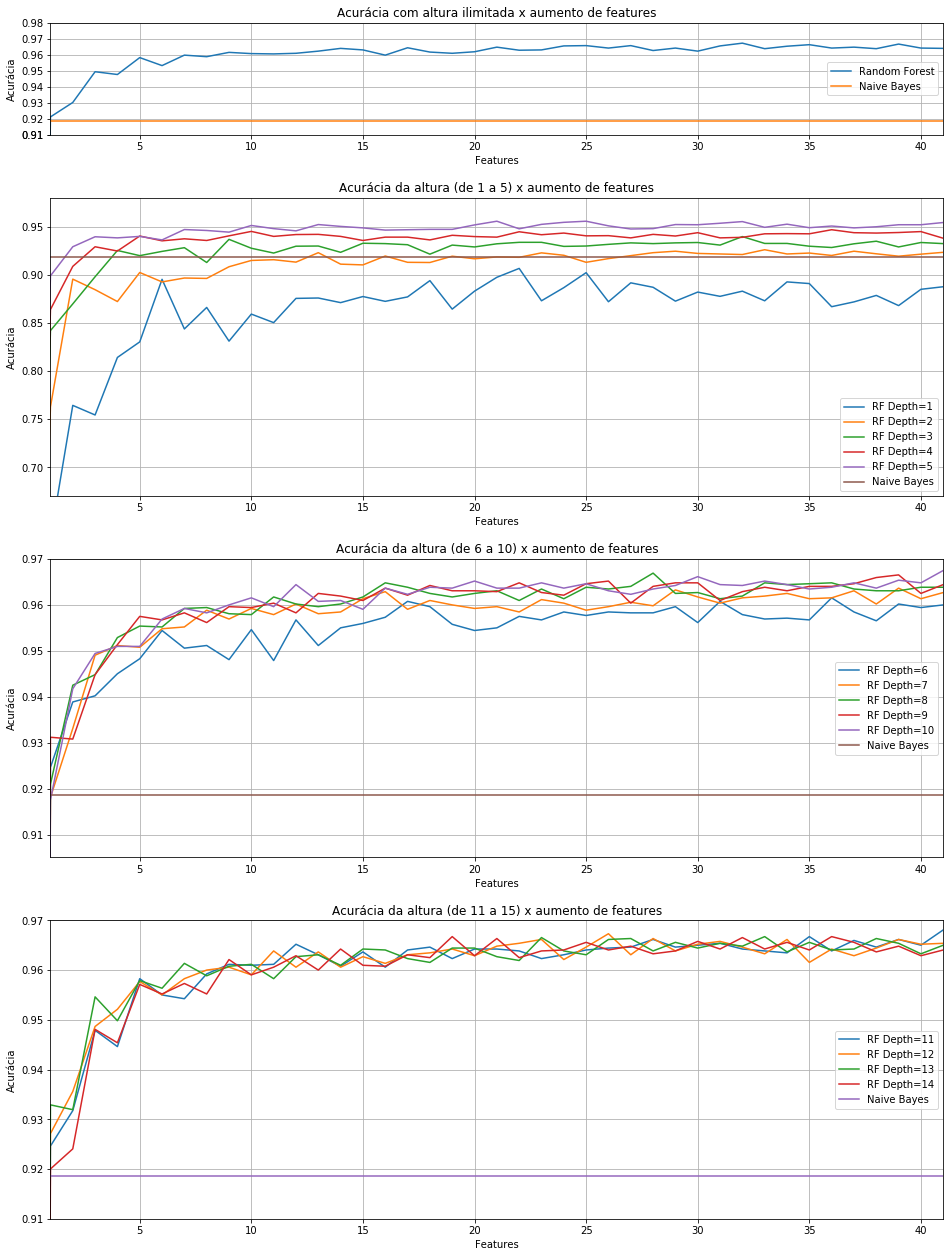

In [11]:
showRandomForestStats(MAX_DEPTH)

Podemos analisar algumas variações na eficiência uma vez que deixamos de utilizar somente uma _Decision Tree_ (experimento anterior) e passamos a utilizar várias utilizando _bagging_ e setando o número de _features_ utilizadas para montar cada uma das várias árvores: O melhor valor para a altura da árvore encontrado no experimento anterior não é mais tão eficiente; isso mostra que para quantidades de features diferentes utilizadas como parâmetros da árvore, diferentes alturas se tornam o melhor o caso.<br>Outro ponto interessante é que o desempenho dos modelos utilizando árvores em que o tamanho não é definido (ou seja, a árvore cresce até que todos os dados estejam separados) passa a ser uma boa opção; o algoritmo agora tendo um número de _features_ definido, trabalha melhor com uma árvore sem limite de tamanho. Podemos dizer que o desempenho do algorítmo _Random Forest_ para este dataset é igualmente eficiente tanto para altura ilimitada quanto para as maiores alturas iguais. Por outro lado, o desempenho utilizando alturas menores ou iguais à 6 tem considerável piora ao definir uma quantidade fixa de _features_, apesar de ganharem acurácia à medida que a quantidade de _features_ aumenta (o que faz sentido: as árvores se tornam pouco capazes de separar os dados de forma eficiente com uma altura limitada __e__ terem poucas _features_ à se utilizar, vão ganhando eficiência ao aumentar a quantidade de _features_ mas continuam com desempenho pior se comparadas à árvores com alturas maiores e mesma quantidade de _features_).

# KNN
Avaliação da acurácia do modelo utilizando _KNN_, em comparação com o _Naive Bayes_.

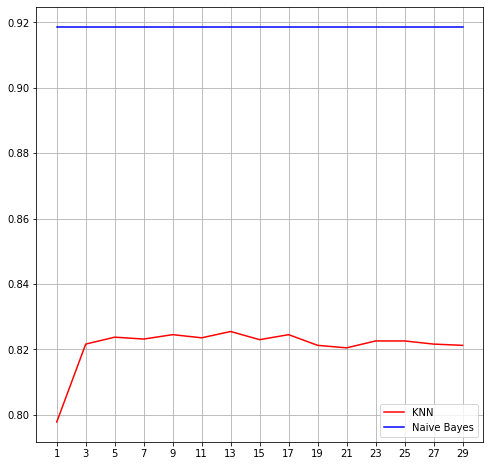

In [26]:
showKnnStats([1,3,5,7,9,11,13,15,17,19,21,23,25,27,29])

{Explicação sobre KNN}

In [22]:
# svmMeanScoreByKernel = svmClassifier(ds.examples['full'], ds.labels['full'], 
#                                      ds.examples['train'], ds.labels['train'], FOLDS_COUNT)

# adaboostMeanScore = adaboostClassifier(ds.examples['full'], ds.labels['full'], 
#                                        ds.examples['train'], ds.labels['train'], 50, FOLDS_COUNT)